### Exercise: using PyTorch to train a small neural network to do MNIST classification. Goal: ~99% test accuracy using a 3-layer convolutional neural network.

In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.transforms as tfms

#### Get training data & show a few example images

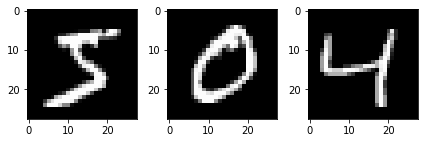

In [3]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=tfms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, download=True, transform=tfms.ToTensor())

fig, axes = plt.subplots(1, 3)
for i in range(3):
    x, _ = mnist_trainset[i]
    ax = axes[i]
    ax.imshow(x.numpy()[0], cmap='gray')
plt.tight_layout()
plt.show()

In [8]:
x.shape

torch.Size([1, 28, 28])

#### Set up model

#### Train

In [ ]:
batch_size = 128